In [1]:
import os
import pandas
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import subprocess
import plotnine as gg

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')


/var/folders/0y/5d1shp9n6kq856jtm9t10mcw0000gq/T/ipykernel_8377/1149045567.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


# Define all variables and set up data import / export

### Data structure and setup:
It may be necessary to do multiple runs of this pipeline in order to compare results. This notebook doesn't assume any existing structure, but will download folders of csvs for the output of Step 7 in the PCP pipeline into a folder of your choosing `csvfolder`. The default will create a file structure like this: 

```
top_folder/
└── PROJECT_NAME/
    └── BATCH_ID/
        └── Jupyter-output/
        └── PLATE-WELL-SITE/
            └── foci_csvs/
                └── BarcodePreprocessing_Foci.csv
                └── BarcodePreprocessing_BarcodeFoci.csv
```

### Results output:
You can define the name of the folder you would like to contain your results in the `jupyter_output` variable below. The results folder is currently set up to be saved in a `batch` folder; you can change that behavior by adjusting the `output_path` variable. Running the cell below will automatically create an output folder if it doesn't exist. 


In [2]:
# Set variables

PROJECT_NAME="2021_09_01_VarChAMP_Vidal_Taipale"
BATCH_ID="2023_01_11_Batch2"
BUCKET="imaging-platform-ssf"
numcycles=8

top_folder = '/Users/rsenft/Downloads/BarcodeProcessing'

# folder w/ barcoding CSV result files
csvfolder = os.path.join(top_folder, PROJECT_NAME, BATCH_ID, "foci_csvs")

# file name for barcode csv
filename = 'BarcodePreprocessing_Foci.csv'

# define the name of a folder to save Jupyter notebook output
jupyter_output = 'Jupyter-output'

# create the output folder if it doesn't exist 
output_path = os.path.join(top_folder, PROJECT_NAME, BATCH_ID, jupyter_output)

if not os.path.isdir(output_path):
    os.makedirs(output_path)

# set row widths for spatial mapping of percent perfect
imperwell = 88


if imperwell == 1364:
        row_widths = [8,14,18,22,26,28,30,
        32,34,34,36,36,38,38,
        40,40,40,42,42,42,42,
        42,42,42,42,40,40,40,
        38,38,36,36,34,34,32,
        30,28,26,22,18,14,8]
elif imperwell == 1332:
        row_widths = [14,18,22,26,28,30,
        32,34,34,36,36,38,38,
        40,40,40,40,40,40,40,
        40,40,40,40,40,40,40,
        38,38,36,36,34,34,32,
        30,28,26,22,18,14]
elif imperwell == 1396:
        row_widths = [18,22,26,28,30,
        32,34,36,36,38,38,
        40,40,40,40,40,40,40,40,40,
        40,40,40,40,40,40,40,40,40,
        38,38,36,36,34,32,
        30,28,26,22,18]
elif imperwell == 320:
        row_widths = [4, 8, 12, 14, 16,
        18, 18, 20, 20, 20,
        20, 20, 20, 20, 18,
        18, 16, 14, 12, 8, 4]
elif imperwell == 316:
        row_widths = [6, 10, 14, 16, 16,
        18, 18, 20, 20, 20,
        20, 20, 20, 18, 18,
        16, 16, 14, 10, 6]
elif imperwell == 293:
        row_widths = [7, 11, 13, 15, 17, 17,
        19, 19, 19, 19, 19, 19, 19, 17, 17,
        15, 13, 11, 7]
elif imperwell == 88:
        row_widths = [6, 8, 10, 10, 10, 10, 10, 10, 8, 6]


In [ ]:
# Download files if necessary
subprocess.run(['aws', 's3', 'sync', 's3://imaging-platform-ssf/projects/'+PROJECT_NAME+'/'+BATCH_ID+'/'+'images_corrected/barcoding/', csvfolder, '--exclude', '*', '--include', '**/*Foci.csv'])

Alternatively, paste this into terminal:

```
PROJECT_NAME=2021_09_01_VarChAMP_Vidal_Taipale
BATCH_ID=2023_01_11_Batch2
STEPNAME=PreprocessBarcoding
STEP=7
BUCKET=imaging-platform-ssf

aws s3 sync s3://${BUCKET}/projects/${PROJECT_NAME}/${BATCH_ID}/images_corrected/barcoding/ Downloads/BarcodeProcessing --exclude="*" --include="**/*Foci.csv"
```

In [3]:
# Useful function for merging CSVs contained in folders within one folder

def merge_csvs(csvfolder, filename, column_list=None):
    """ csvfolder is a path to a folder
    Iterates over all of the folders inside of that CSVfolder
    Merges the CSVs that match the filename into one dataframe 
    If a column list is passed, it keeps columns defined in the column list
    Prints a time stamp every 500 csvs
    Returns the merged dataframe
    """

    df_dict={}
    count = 0
    folderlist = os.listdir(csvfolder)
    print(count, datetime.datetime.ctime(datetime.datetime.now()))
    for eachfolder in folderlist:
            if os.path.isfile(os.path.join(csvfolder, eachfolder, filename)):
                if not column_list:
                    df_dict[eachfolder]=pandas.read_csv(os.path.join(csvfolder, eachfolder, filename),index_col=False)
                else:
                    df_dict[eachfolder]=pandas.read_csv(os.path.join(csvfolder, eachfolder, filename),index_col=False,usecols=column_list)
                count+=1
                if count % 500 == 0:
                    print(count, datetime.datetime.ctime(datetime.datetime.now()))
    print(count, datetime.datetime.ctime(datetime.datetime.now()))
    df_merged = pandas.concat(df_dict, ignore_index=True)
    print('done concatenating at', datetime.datetime.ctime(datetime.datetime.now()))
    
    return df_merged

# Merge CSVs

The first step is to merge the various CSVs for our experiment.
- The CSVs are stored in separate folders for each Well-Site and will be merged into one CSV in the next step.
- The `_BarcodeFoci.csv` files contain the % perfect match to the barcode score within the `Intensity_..._Barcodes_Scores` columns. 
- The `_Foci.csv` files contain the text for the barcode called and the barcode matched along with a matching score
- The Metadata columns are included in these CSVs 


In [ ]:
# OPTIONAL read a single BarcodeFoci csv to determine the columns present in the data
filename = 'BarcodePreprocessing_Foci.csv'

sample_csv_df = pandas.read_csv(os.path.join(csvfolder, os.listdir(csvfolder)[0], filename))

# print the column list; copy-edit this list if desired 

print(list(sample_csv_df.columns))
# use this column list can be used to select the columns needed in the merged CSV, if desired  

In [ ]:
# Merge BarcodeFoci csvs
#Run if csvs are in separate folders
filename = 'BarcodePreprocessing_Foci.csv'
column_list = ['ImageNumber', 'ObjectNumber', 'Metadata_Plate', 'Metadata_Site', 'Metadata_Well', 'Metadata_Well_Value', 'Barcode_BarcodeCalled', 'Barcode_MatchedTo_Barcode', 'Barcode_MatchedTo_GeneCode', 'Barcode_MatchedTo_ID', 'Barcode_MatchedTo_Score']

df_foci = merge_csvs(csvfolder, filename, column_list)

In [ ]:
#Save the merged BarcodeFoci CSV
output_filename = 'BarcodePreprocessing_Foci_Merged.csv'

foci_path = os.path.join(output_path, output_filename)
df_foci.to_csv(foci_path)

# Load Merged CSVs

If you've already merged and save your CSVs using the code above, you can skip to this step of the notebook. 


In [4]:
# List the contents of the Jupyter notebook output path
# See what CSVs have been saved and their names

drivelist = os.listdir(output_path)
filelist = [x for x in drivelist if not os.path.isdir(os.path.join(top_folder,x)) ]
print(filelist)

['BarcodePreprocessing_Foci_Merged.csv', 'barcodes-by-well.txt', 'barcode-score-by-well.png', 'percent-perfect.csv', 'barcode-score-distribution.png', 'barcodes-per-cell-distribution.png']


In [5]:
# Load the CSVs into data frames

df_foci = pandas.read_csv(os.path.join(output_path, 'BarcodePreprocessing_Foci_Merged.csv'))

## Optional filtering out certain sites

In [ ]:
# Optional: filtering the edge wells out:
edge_wells=[81, 82, 83, 84, 85, 86, 87, 
            73, 74, 63, 64, 53, 54,
            43, 44, 33, 34, 
            13, 14, 23, 24, 
            0, 1, 2, 3, 4, 5, 6]

#uncomment the following line to filter out edge cells
#df_foci = df_foci[~df_foci.Metadata_Site.isin(edge_wells)]

# Investigating barcode calling

In [6]:
# useful dataframe manipulations 

df_foci.sort_values(by=['Metadata_Well_Value', 'Metadata_Site'], inplace=True)

df_foci['well-site'] = df_foci['Metadata_Well_Value'] + '-' + df_foci['Metadata_Site'].astype(str)

df_foci_well_groups = df_foci.groupby("Metadata_Well_Value")

df_foci.head()

,Unnamed: 0,ImageNumber,ObjectNumber,Metadata_Plate,Metadata_Site,Metadata_Well,Metadata_Well_Value,Barcode_BarcodeCalled,Barcode_MatchedTo_Barcode,Barcode_MatchedTo_GeneCode,Barcode_MatchedTo_ID,Barcode_MatchedTo_Score,well-site
128368,128368,1,1,Baseline2_C1-6_11292022,0,WellC1,WellC1,TAAAATAA,TGAAATCAACAG,TUBB2B,282,0.75,WellC1-0
128369,128369,1,2,Baseline2_C1-6_11292022,0,WellC1,WellC1,TAAAAAAA,TAAAGACACTGT,SLC14A1,291,0.75,WellC1-0
128370,128370,1,3,Baseline2_C1-6_11292022,0,WellC1,WellC1,TATAAAAA,TATCAAACGATA,PRODH L289M,247,0.75,WellC1-0
128371,128371,1,4,Baseline2_C1-6_11292022,0,WellC1,WellC1,TAAAAAAA,TAAAGACACTGT,SLC14A1,291,0.75,WellC1-0
128372,128372,1,5,Baseline2_C1-6_11292022,0,WellC1,WellC1,TAAAAAAA,TAAAGACACTGT,SLC14A1,291,0.75,WellC1-0


### Distribution of barcode foci scores overall

/var/folders/0y/5d1shp9n6kq856jtm9t10mcw0000gq/T/ipykernel_8377/1083129149.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



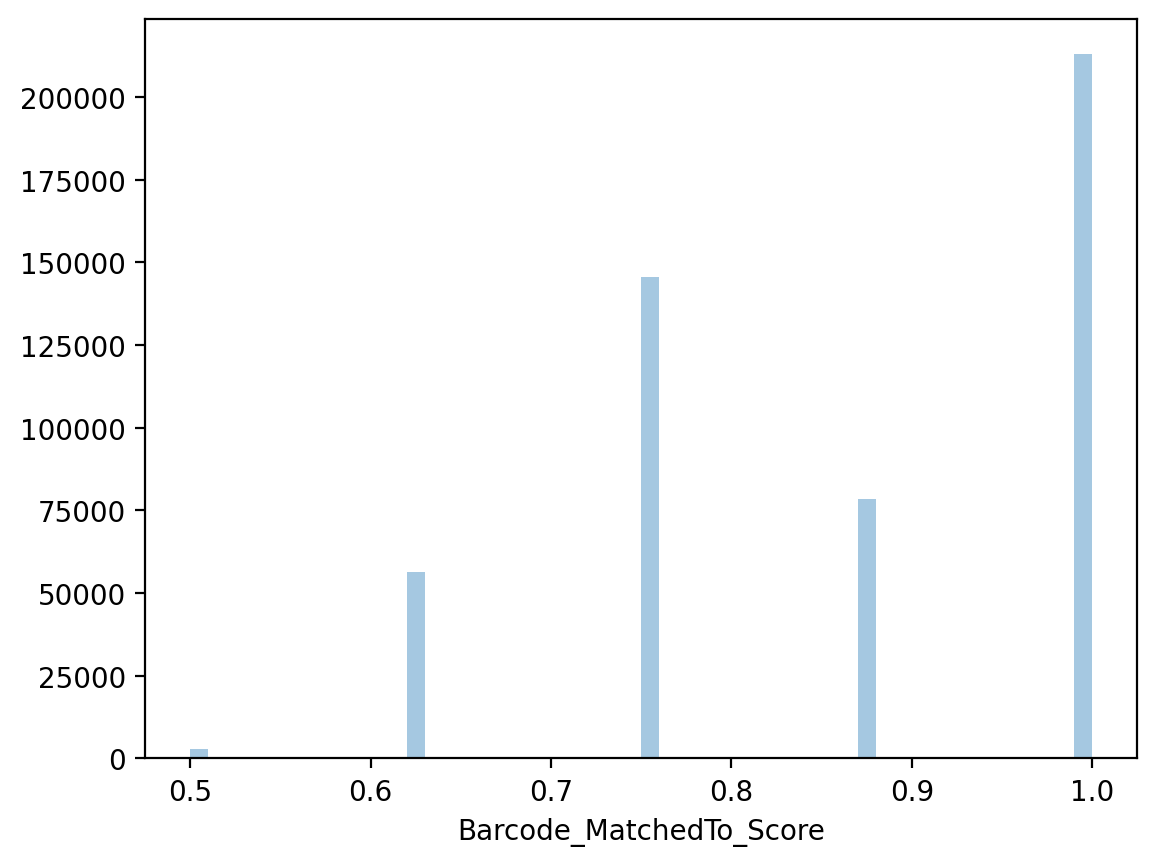

In [7]:
sns.distplot(df_foci['Barcode_MatchedTo_Score'], kde=False)


distplot_filename = "barcode-score-distribution.png"
distplot_path = os.path.join(output_path, distplot_filename)

plt.savefig(distplot_path, dpi=300)

### Distribution of barcode matching scores by well:

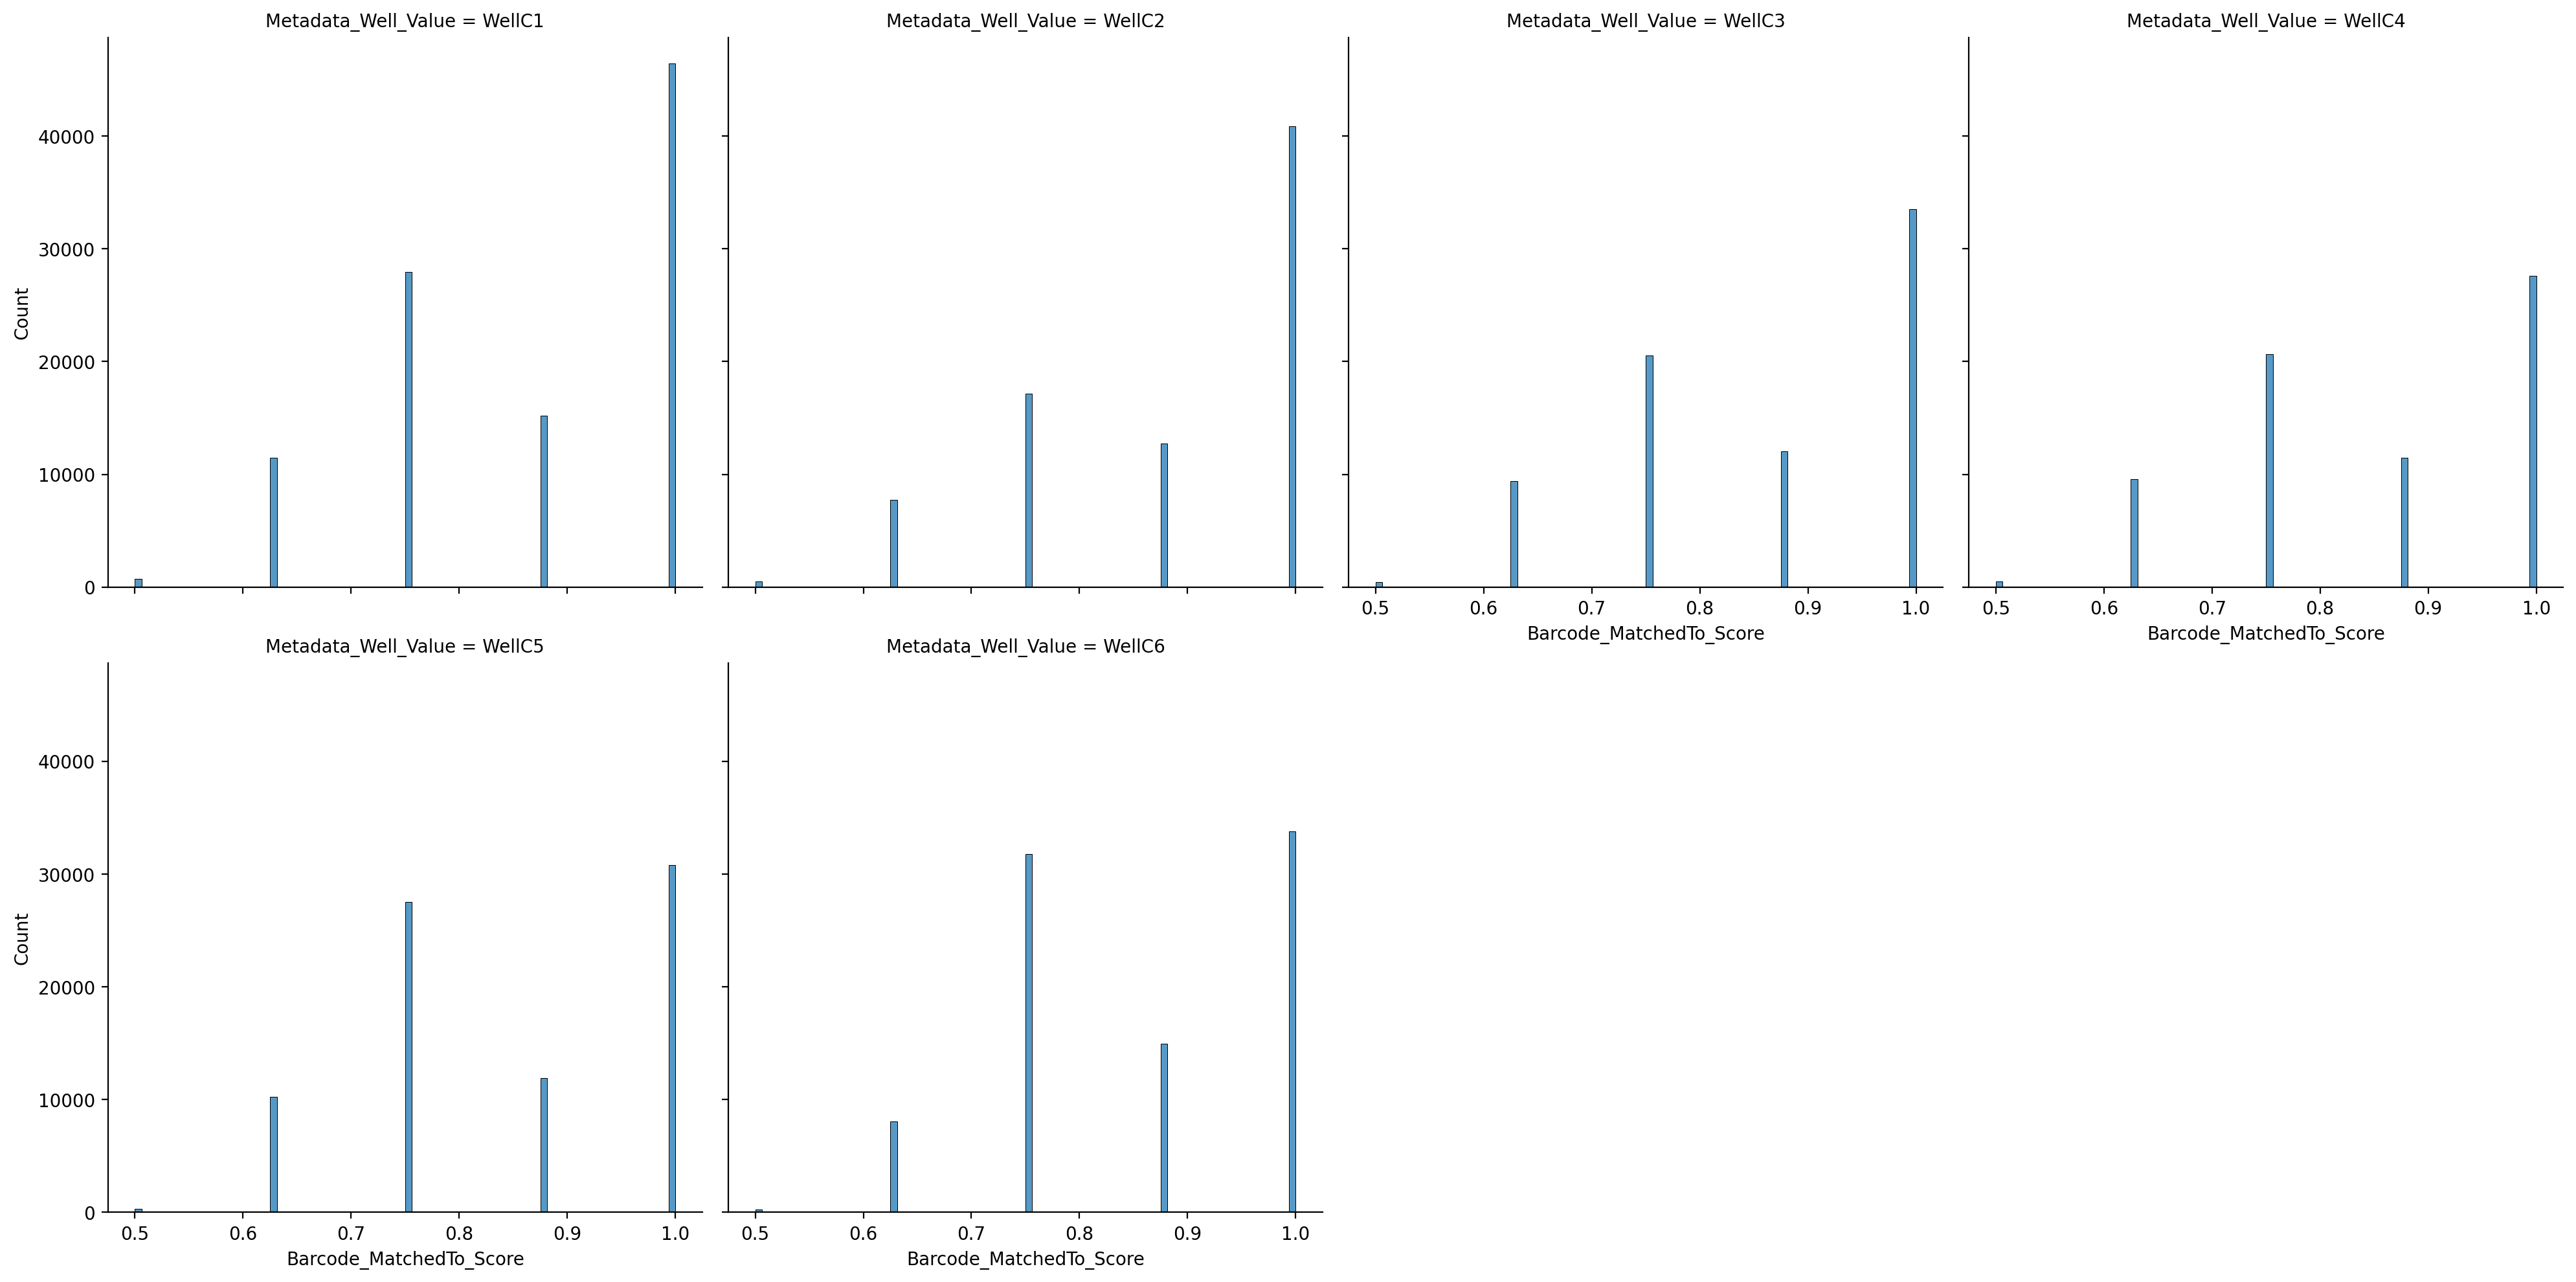

In [8]:
sns_displot = sns.displot(
    df_foci, x="Barcode_MatchedTo_Score", col="Metadata_Well_Value", col_wrap=4
)

displot_filename = "barcode-score-by-well.png"
displot_path = os.path.join(output_path, displot_filename)

sns_displot.savefig(displot_path, dpi=300)

### Statistics about barcodes called
The strings for the barcodes are saved in `Foci.csv` files for each well. Investigate: are the barcodes that are called most frequently all one letter? Are the bases (A, T, G, C) called an equal # of times? What percentage of barcodes are called at 100% accuracy? 

Since we have high variability between wells, we'll do this on a per well basis. That will help us to estimate if the barcodes are called inaccurately in different ways for each well. (For example, visual inspection of the Barcodes called for WellD4-Site41 suggests that "A" is being called at very high frequency).


#### Which barcodes are called most often?

In [9]:
# Which barcodes are being called most often?
# Wells with barcodes like AAAAAAA called most often are probably low quality
# print to this notebook and save in a text file

barcode_filename = "barcodes-by-well.txt"
barcode_filepath = os.path.join(output_path, barcode_filename)

with open(barcode_filepath, "w") as barcode_file:

    for well, df_foci_well in df_foci_well_groups:
        print(well)
        print(df_foci_well['Barcode_BarcodeCalled'].value_counts().head(10), '\n')
        
        barcode_file.write(well + '\n')
        barcode_file.write(str(df_foci_well['Barcode_BarcodeCalled'].value_counts().head(10)) + '\n\n')

barcode_file.close()


WellC1
TACTCCAA    5076
GGCCCCCC    3914
TGCCCCCC    2368
GGCCGCCC    2258
TCAACGTG    1942
CATTAAGT    1646
CCAAGCCA    1591
CCGTTTTA    1497
GGGCGCCC    1108
CCAGAACT     990
Name: Barcode_BarcodeCalled, dtype: int64 

WellC2
TACTCCAA    4514
GGCCCCCC    2010
TCAACGTG    1705
CCAAGCCA    1523
TGCCCCCC    1460
CATTAAGT    1404
CCGTTTTA    1371
GGGCGCCC    1287
GGCCGCCC    1146
TTCTGTTT     878
Name: Barcode_BarcodeCalled, dtype: int64 

WellC3
TACTCCAA    3537
GGCCCCCC    2175
TGCCCCCC    1796
TCAACGTG    1326
CATTAAGT    1229
CCAAGCCA    1072
CCGTTTTA    1072
GGGCGCCC     994
TCCCCCCC     979
GGCCGCCC     774
Name: Barcode_BarcodeCalled, dtype: int64 

WellC4
TACTCCAA    3436
GGCCCCCC    2639
TGCCCCCC    1889
CCAAGCCA    1461
GGGCGCCC    1272
CATTAAGT    1061
GGCCGCCC    1045
CCGTTTTA     912
TCAACGTG     839
ACATCCTC     815
Name: Barcode_BarcodeCalled, dtype: int64 

WellC5
GGCCCCCC    4049
TACTCCAA    3781
TGCCCCCC    3546
CCAAGCCA    1396
TTCCCCCC    1217
CATTAAGT    1193
TCAACGT

#### What is the frequency of each base in called barcodes?

In [10]:
# What is the % of each base?

BarcodeCat = df_foci['Barcode_BarcodeCalled'].str.cat()

countG = BarcodeCat.count('G')
countT = BarcodeCat.count('T')
countA = BarcodeCat.count('A')
countC = BarcodeCat.count('C')

print ("Frequency of A is " + str(float(countA)/float((len(BarcodeCat)))*100))
print ("Frequency of C is " + str(float(countC)/float((len(BarcodeCat)))*100))
print ("Frequency of G is " + str(float(countG)/float((len(BarcodeCat)))*100))
print ("Frequency of T is " + str(float(countT)/float((len(BarcodeCat)))*100))

# 39% GC in the probes themselves; A & T should be roughly 30% each 


Frequency of A is 22.58871660276491
Frequency of C is 35.72511359192379
Frequency of G is 18.50011288638389
Frequency of T is 23.186056918927417


### Nucleotide distribution over cycles

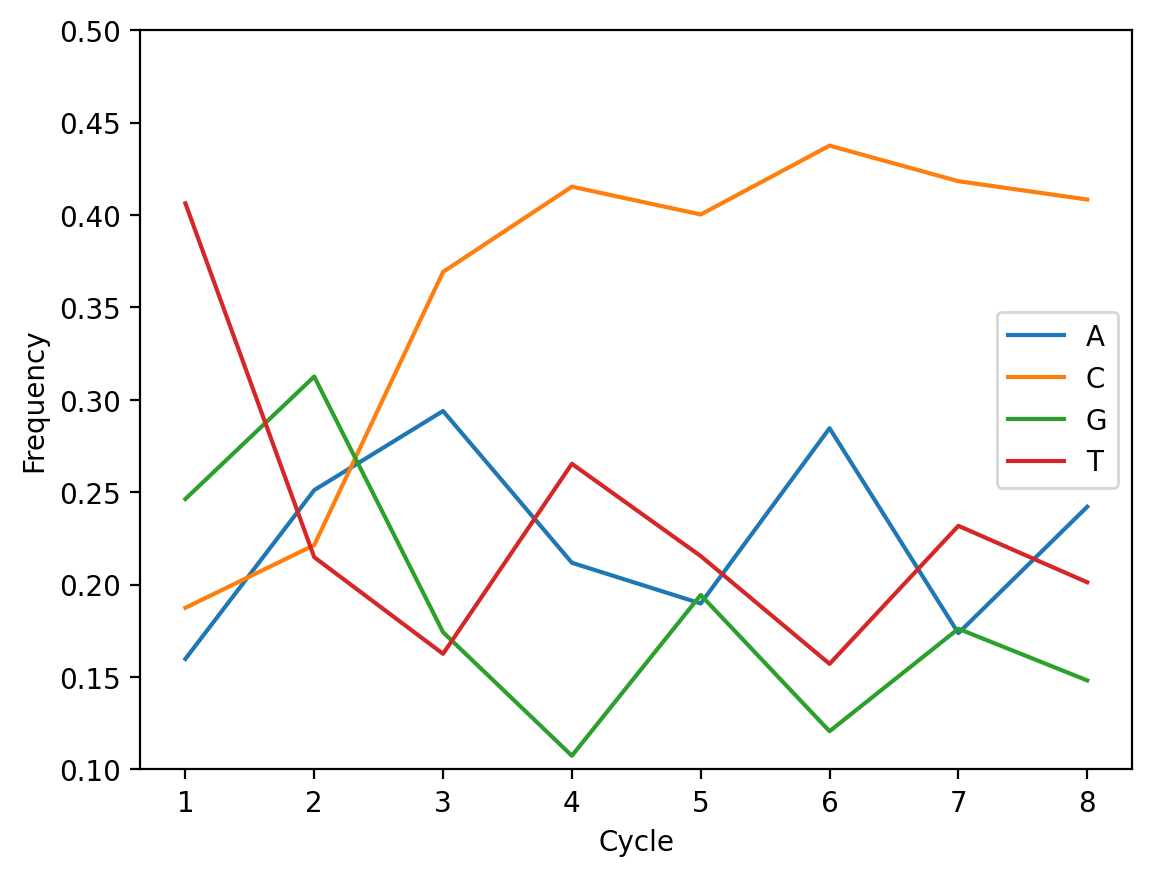

In [11]:
dflist = []
for cycle in range(1,numcycles+1):
    df_foci['PerCycle'] = df_foci['Barcode_BarcodeCalled'].str.slice(cycle -1, cycle)
    BarcodeCat = df_foci['PerCycle'].str.cat()
    dflist.append({'Cycle' : int(cycle), 'Nucleotide' : 'A', 'Frequency' : float(BarcodeCat.count('A'))/float(len(BarcodeCat))})
    dflist.append({'Cycle' : int(cycle), 'Nucleotide' : 'C', 'Frequency' : float(BarcodeCat.count('C'))/float(len(BarcodeCat))})
    dflist.append({'Cycle' : int(cycle), 'Nucleotide' : 'G', 'Frequency' : float(BarcodeCat.count('G'))/float(len(BarcodeCat))})
    dflist.append({'Cycle' : int(cycle), 'Nucleotide' : 'T', 'Frequency' : float(BarcodeCat.count('T'))/float(len(BarcodeCat))})
df_parsed = pandas.DataFrame(dflist)
g = sns.lineplot(x="Cycle", y="Frequency", hue="Nucleotide", data=df_parsed)
g.set_ylim([.1,.5])
handles, labels = g.get_legend_handles_labels()
g.legend(handles=handles[0:], labels=labels[0:])
g.set_xticks(list(range(1,numcycles+1)))

This is concerning! Want them to be much more flat. Background in C channel accumulates over time. C spots may be background spots. 

### Percent barcode calls with >4 nucleotide repeats

In [12]:
readlist = df_foci['Barcode_BarcodeCalled']
print ('% Reads with >4 repeat nucleotide calls')
print (100*pandas.Series([any(repeat in read for repeat in ['AAAAA','CCCCC','GGGGG','TTTTT']) for read in readlist]).mean())

% Reads with >4 repeat nucleotide calls
17.87475255707818


We can likely reduce this on our end (with image analysis)
* Barcode calling (bad compensation)
* Foci calling

### Base distribution and percent perfect by well (table)

In [13]:
# let's investigate % base distribution by well

well_site_ls = []
percent_close_ls = []
percent_perfect_ls = []
perfect_barcode_count_ls = []
frequency_A_ls = []
frequency_C_ls = []
frequency_G_ls = []
frequency_T_ls = []

for well, df_foci_well in df_foci_well_groups:
    BarcodeCat = df_foci_well['Barcode_BarcodeCalled'].str.cat()

    countG = BarcodeCat.count('G')
    countT = BarcodeCat.count('T')
    countA = BarcodeCat.count('A')
    countC = BarcodeCat.count('C')

    well_site_ls.append(df_foci_well['Metadata_Well_Value'].iloc[0])    
    percent_close_ls.append(sum(df_foci_well['Barcode_MatchedTo_Score']>=0.875)*100.0/sum(df_foci_well['Barcode_MatchedTo_Score']>0))
    percent_perfect_ls.append(sum(df_foci_well['Barcode_MatchedTo_Score']==1)*100.0/sum(df_foci_well['Barcode_MatchedTo_Score']>0))    
    perfect_barcode_count_ls.append(sum(df_foci_well['Barcode_MatchedTo_Score']==1))
    
    frequency_A_ls.append(float(countA)/float((len(BarcodeCat)))*100)
    frequency_C_ls.append(float(countC)/float((len(BarcodeCat)))*100)
    frequency_G_ls.append(float(countG)/float((len(BarcodeCat)))*100)
    frequency_T_ls.append(float(countT)/float((len(BarcodeCat)))*100)
        
percent_perfect_df = pandas.DataFrame({'Metadata_Well_Value': well_site_ls, 
                                       'percent-perfect': percent_perfect_ls,
                                       'percent-close': percent_close_ls, 
                                       'perfect-barcode-count': perfect_barcode_count_ls,
                                       'frequency-A': frequency_A_ls,
                                       'frequency-C': frequency_C_ls,
                                       'frequency-G': frequency_G_ls,
                                       'frequency-T': frequency_T_ls,
                                      })

In [14]:
# save the % perfect dataframe to disk
percent_perfect_df_filename = 'percent-perfect.csv'

percent_perfect_path = os.path.join(output_path, percent_perfect_df_filename)

percent_perfect_df.to_csv(percent_perfect_path)

# % perfect, % close, and perfect barcode count data
percent_perfect_df

,Metadata_Well_Value,percent-perfect,percent-close,perfect-barcode-count,frequency-A,frequency-C,frequency-G,frequency-T
0,WellC1,45.579107,60.512513,46405,24.213870,34.515209,18.596408,22.674513
1,WellC2,51.703704,67.845521,40833,22.962330,33.740741,18.184710,25.112219
2,WellC3,44.158207,59.997363,33494,22.729895,34.050264,18.808668,24.411173
3,WellC4,39.540582,55.988479,27593,21.022906,36.333364,20.175649,22.468080
4,WellC5,38.136191,52.883818,30819,23.246105,37.083297,17.596024,22.074573
5,WellC6,38.008780,54.868303,33767,20.905561,38.592413,17.912962,22.589065


## Plotting percent perfect by site

In [15]:
# Pos df
# Creates x, y coordinates for plotting per-plate views.

max_width = max(row_widths)
pos_dict = {}
count = 0
# creates dict of (xpos,ypos) = imnumber
for row in range(len(row_widths)):
    row_width = row_widths[row]
    left_pos = int((max_width-row_width)/2)
    for col in range(row_width):
        if row%2 == 0:
            pos_dict[(int(left_pos + col), row)] = count
            count += 1
        else:
            right_pos = left_pos + row_width - 1
            pos_dict[(int(right_pos - col), row)] = count
            count += 1
# make dict into df
pos_df = pandas.DataFrame.from_dict(pos_dict, orient = "index").reset_index().rename(columns={"index": "loc", 0: "Metadata_Site"})
pos_df[['x_loc', 'y_loc']] = pandas.DataFrame(pos_df['loc'].tolist(), index=pos_df.index) 

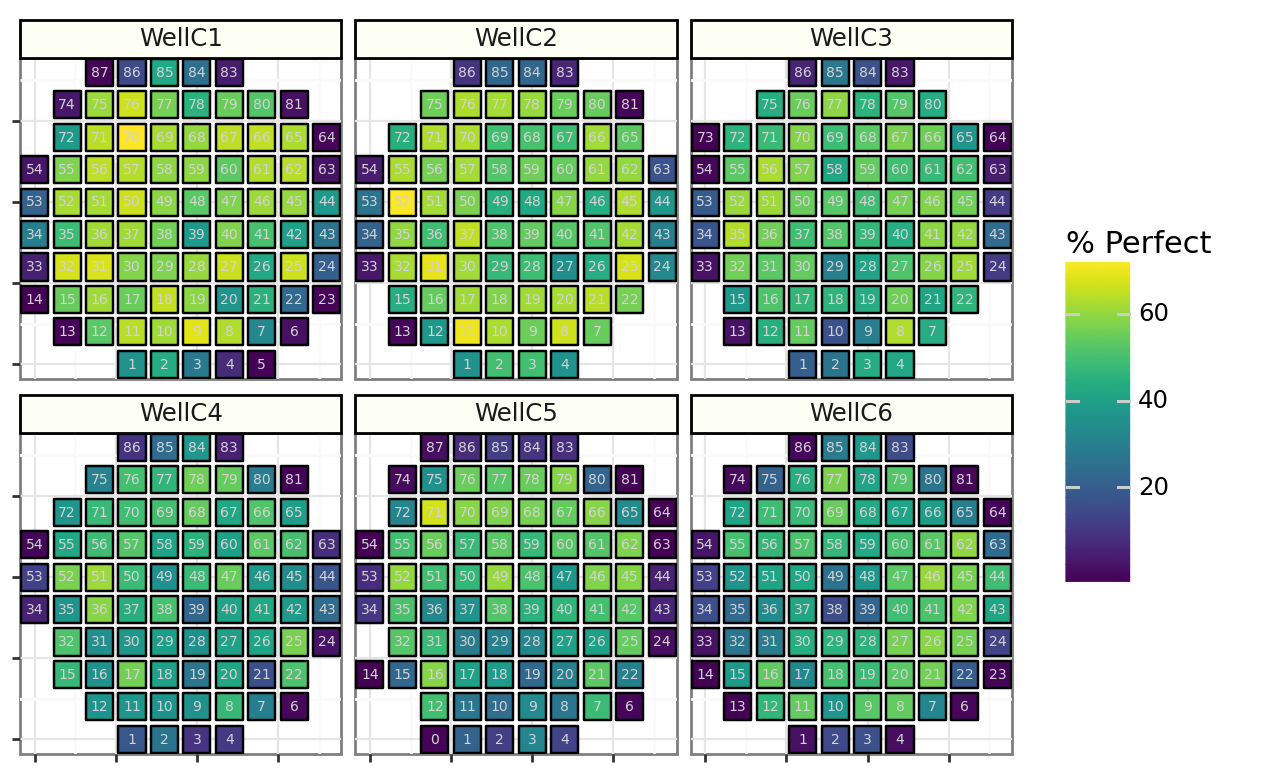

<ggplot: (8793099299485)>

In [16]:
# % Perfect by well
df_foci_slice = df_foci.loc[:, ['Metadata_Well', 'Metadata_Site', 'Barcode_MatchedTo_Score']]
df_foci_perf = df_foci_slice[df_foci_slice['Barcode_MatchedTo_Score']==1]
df_foci_perf = (
    df_foci_perf.groupby(["Metadata_Well", "Metadata_Site"])
    .count()
    .reset_index()
    .rename(columns={"Barcode_MatchedTo_Score": "Num_Perf"})
)
df_foci_slice = (
    df_foci_slice.groupby(["Metadata_Well", "Metadata_Site"])
    .count()
    .reset_index()
    .rename(columns={"Barcode_MatchedTo_Score": "Num_Total"})
)
df_foci_pp = df_foci_perf.merge(df_foci_slice, on = ['Metadata_Well', 'Metadata_Site'])
df_foci_pp["PerPerf"] = (df_foci_pp["Num_Perf"] / df_foci_pp["Num_Total"])*100

# Add the location to the foci dfs
df_foci_pp = df_foci_pp.merge(pos_df, on='Metadata_Site').reset_index()

per_perf_gg = (
    gg.ggplot(df_foci_pp, gg.aes(x="x_loc", y="y_loc"))
    + gg.geom_point(gg.aes(fill="PerPerf"), shape="s", size=5)
    + gg.geom_text(gg.aes(label="Metadata_Site"), color="lightgrey", size=5)
    + gg.facet_wrap("~Metadata_Well")
    + gg.coord_fixed()
    + gg.theme_bw()
    + gg.theme(
        axis_text=gg.element_blank(),
        axis_title=gg.element_blank(),
        strip_background=gg.element_rect(colour="black", fill="#fdfff4"),
    )
    + gg.labs(fill="% Perfect")
    + gg.scale_fill_cmap(name="% Perfect")
)
# note missing sites indicate that site has zero perfect barcodes
per_perf_gg

Again, suggests throw out the edge sites!

## Library coverage
What fraction of possible barcodes are found in the data?

In [17]:
#download csv for barcode library
barcodes_file=os.path.join(top_folder, "Barcodes.csv")
subprocess.run(['aws', 's3', 'cp', 's3://imaging-platform-ssf/projects/'+PROJECT_NAME+'/workspace/metadata/'+BATCH_ID+'/'+'Barcodes.csv', barcodes_file])

KeyboardInterrupt: 

In [18]:
# read file
barcodes_csv=pandas.read_csv(barcodes_file)

The number of unique entries in the library is 295 and perfect barcodes are detected for 278 of them


LZTR1          24362
RPS19           8428
RPS19 R101H     8138
RPS19 G127E     7705
AHCY            6752
Name: Barcode_MatchedTo_GeneCode, dtype: int64

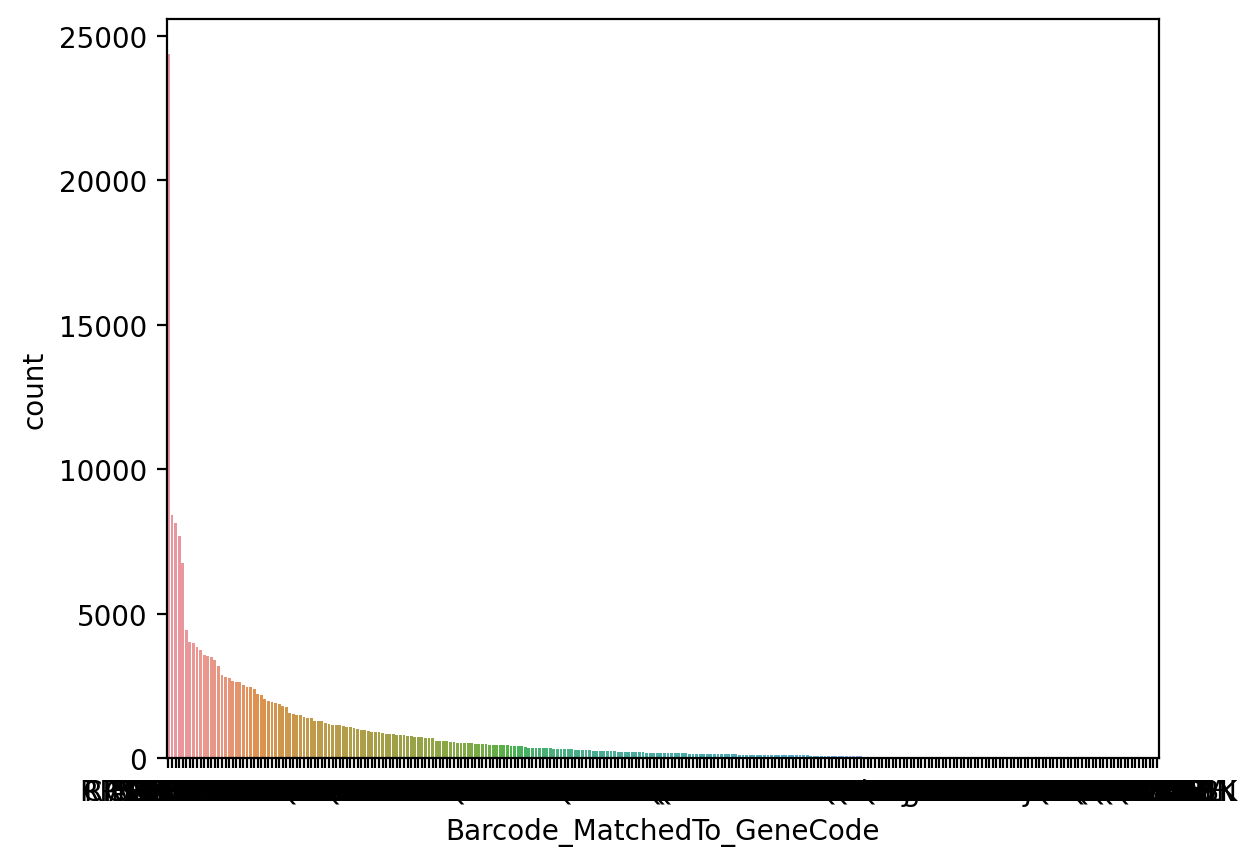

In [19]:
# get number of unique library entries with at least 1 perfect barcode
perfect_matches_only_df = df_foci[df_foci["Barcode_MatchedTo_Score"]==1]
unique_perfect_matches=perfect_matches_only_df.Barcode_MatchedTo_GeneCode.unique()
print(f"The number of unique entries in the library is {len(barcodes_csv['Construct'])} and perfect barcodes are detected for {len(unique_perfect_matches)} of them")

sns.countplot(data=perfect_matches_only_df, x="Barcode_MatchedTo_GeneCode", dodge=False, order = perfect_matches_only_df['Barcode_MatchedTo_GeneCode'].value_counts().index)
perfect_matches_only_df.Barcode_MatchedTo_GeneCode.value_counts().head()

## Per-cell metrics
Remember that this cell count is based from segmentaion done with DAPI, not the cell painting dyes. It is much less likely to be accurate so take counts with a grain of salt.

In [ ]:
# Download files if necessary
subprocess.run(['aws', 's3', 'sync', 's3://imaging-platform-ssf/projects/'+PROJECT_NAME+'/'+BATCH_ID+'/'+'images_corrected/barcoding/', csvfolder, '--exclude', '*', '--include', '**/*_Cells.csv'])

In [40]:
#Merge Cells csvs
#Run if csvs are in separate folders
filename = 'BarcodePreprocessing_Cells.csv'
column_list = ['ImageNumber', 'ObjectNumber', 'Metadata_Plate', 'Metadata_Site', 'Metadata_Well', 'Metadata_Well_Value', 'Children_BarcodeFoci_Count']

df_cells = merge_csvs(csvfolder, filename, column_list)
df_cells.head()

0 Fri Feb 17 12:05:15 2023
500 Fri Feb 17 12:05:22 2023
528 Fri Feb 17 12:05:23 2023
done concatenating at Fri Feb 17 12:05:23 2023


,ImageNumber,ObjectNumber,Metadata_Plate,Metadata_Site,Metadata_Well,Metadata_Well_Value,Children_BarcodeFoci_Count
0,44,1,Baseline2_C1-6_11292022,15,WellC2,C2,0
1,44,2,Baseline2_C1-6_11292022,15,WellC2,C2,0
2,44,3,Baseline2_C1-6_11292022,15,WellC2,C2,0
3,44,4,Baseline2_C1-6_11292022,15,WellC2,C2,0
4,44,5,Baseline2_C1-6_11292022,15,WellC2,C2,1


Mean # barcode foci per cell (rough identification): 0.2996033350208283
Total # identified cells: 1607906
Percent of cells with at least 1 barcode foci: 22.268714713422302
Percent of cells with 0 barcode foci: 77.7312852865777


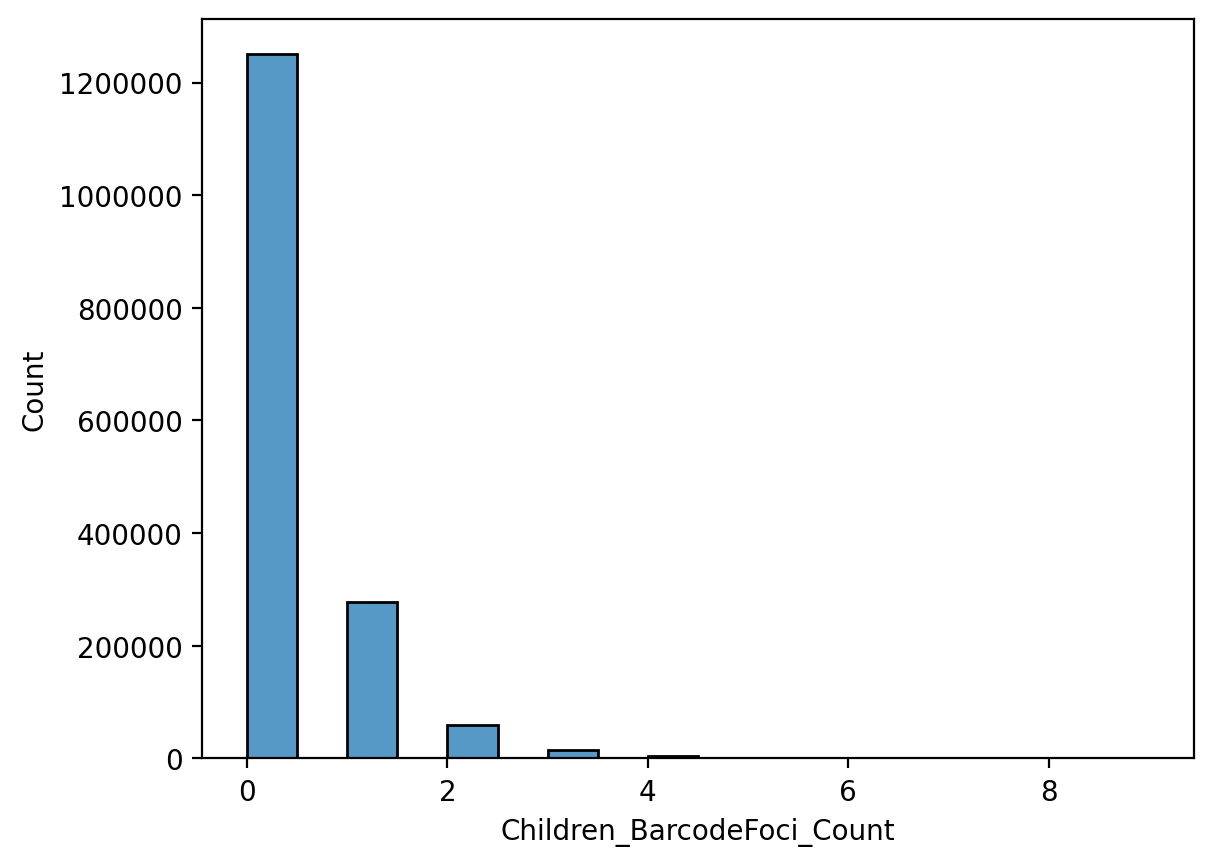

In [41]:
#plot
sns.histplot(df_cells.loc[df_cells['Children_BarcodeFoci_Count'] <10]['Children_BarcodeFoci_Count'], binwidth=0.5)


#change the x scale 
print(f"Mean # barcode foci per cell (rough identification): {df_cells['Children_BarcodeFoci_Count'].mean()}")
print(f"Total # identified cells: {df_cells['Children_BarcodeFoci_Count'].count()}")
print(f"Percent of cells with at least 1 barcode foci: {100*sum(df_cells['Children_BarcodeFoci_Count']>0) / df_cells['Children_BarcodeFoci_Count'].count()}")
print(f"Percent of cells with 0 barcode foci: {100*sum(df_cells['Children_BarcodeFoci_Count']==0) / df_cells['Children_BarcodeFoci_Count'].count()}")

distplot_filename = "barcodes-per-cell-distribution.png"
distplot_path = os.path.join(output_path, distplot_filename)
plt.ticklabel_format(style='plain', axis='y')

plt.savefig(distplot_path, dpi=300)

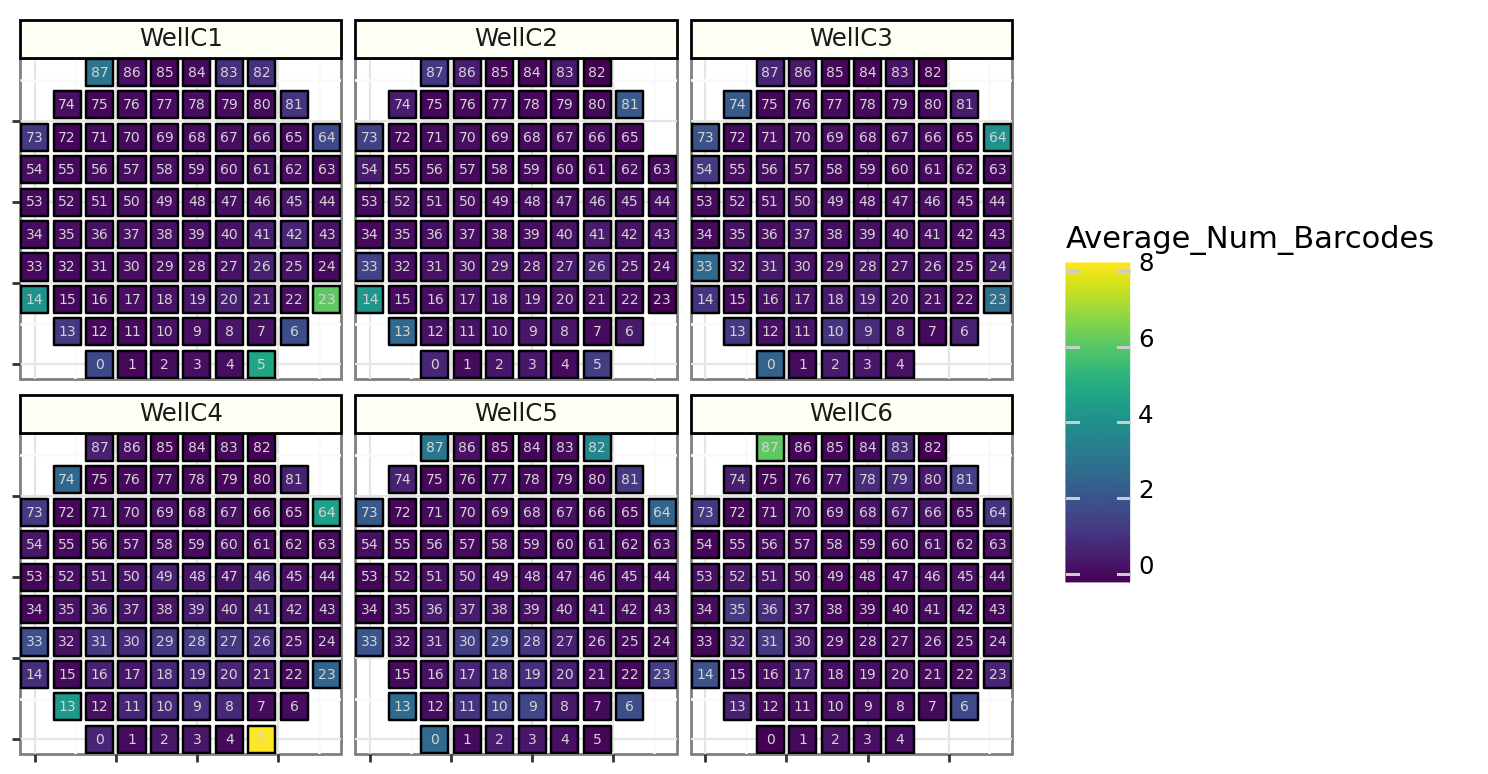

<ggplot: (8793149766964)>

In [22]:
# Number of barcode foci per cell by well

df_cells_slice = df_cells.loc[:, ['Metadata_Well', 'Metadata_Site', 'Children_BarcodeFoci_Count']]

#limit to range between 0 and 10 per cell to be able to see in plot
df_cells_slice = df_cells_slice[(df_cells_slice['Children_BarcodeFoci_Count']<10)&(df_cells_slice['Children_BarcodeFoci_Count']>=0)]

df_cells_slice = (
    df_cells_slice.groupby(["Metadata_Well", "Metadata_Site"])
    .mean()
    .reset_index()
    .rename(columns={"Children_BarcodeFoci_Count": "Average_Num_Barcodes"})
)
df_cells_bc = df_cells_slice.merge(pos_df, on='Metadata_Site').reset_index()

gg_cells = (
    gg.ggplot(df_cells_bc, gg.aes(x="x_loc", y="y_loc"))
    + gg.geom_point(gg.aes(fill="Average_Num_Barcodes"), shape="s", size=5)
    + gg.geom_text(gg.aes(label="Metadata_Site"), color="lightgrey", size=5)
    + gg.facet_wrap("~Metadata_Well")
    + gg.coord_fixed()
    + gg.theme_bw()
    + gg.theme(
        axis_text=gg.element_blank(),
        axis_title=gg.element_blank(),
        strip_background=gg.element_rect(colour="black", fill="#fdfff4"),
    )
    + gg.labs(fill="Average_Num_Barcodes")
    + gg.scale_fill_cmap(name="Average_Num_Barcodes")
)
# note missing sites indicate that site has zero perfect barcodes
gg_cells

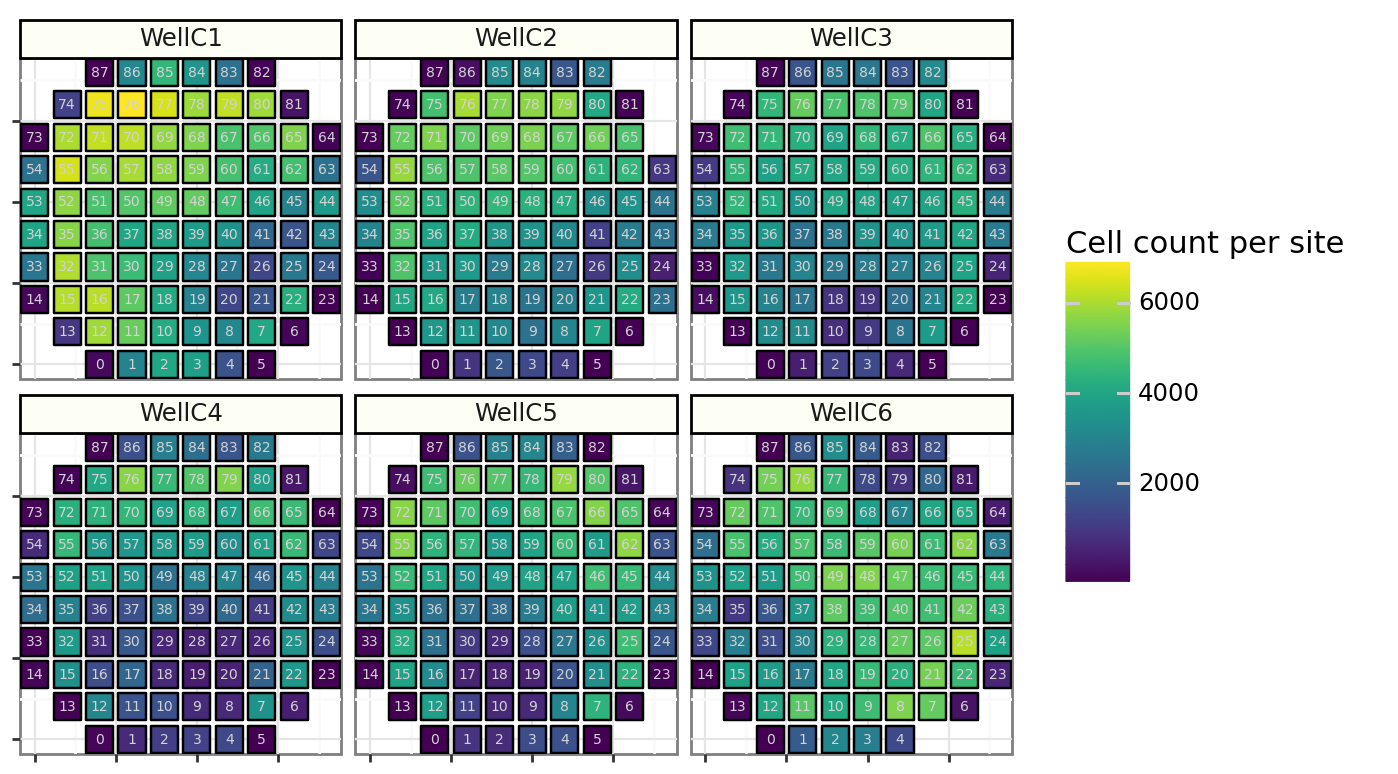

<ggplot: (8793201122033)>

In [23]:
# of cells per site

df_cells_slice = df_cells.loc[:, ['Metadata_Well', 'Metadata_Site', 'Children_BarcodeFoci_Count']]

#limit to range between 0 and 10 per cell to be able to see in plot
#df_cells_slice = df_cells_slice[(df_cells_slice['Children_BarcodeFoci_Count']<10)&(df_cells_slice['Children_BarcodeFoci_Count']>=0)]

df_cells_slice = (
    df_cells_slice.groupby(["Metadata_Well", "Metadata_Site"])
    .count()
    .reset_index()
    .rename(columns={"Children_BarcodeFoci_Count": "Count_cells"})
)
df_cells_bc = df_cells_slice.merge(pos_df, on='Metadata_Site').reset_index()

gg_cells = (
    gg.ggplot(df_cells_bc, gg.aes(x="x_loc", y="y_loc"))
    + gg.geom_point(gg.aes(fill="Count_cells"), shape="s", size=5)
    + gg.geom_text(gg.aes(label="Metadata_Site"), color="lightgrey", size=5)
    + gg.facet_wrap("~Metadata_Well")
    + gg.coord_fixed()
    + gg.theme_bw()
    + gg.theme(
        axis_text=gg.element_blank(),
        axis_title=gg.element_blank(),
        strip_background=gg.element_rect(colour="black", fill="#fdfff4"),
    )
    + gg.labs(fill="Count_cells")
    + gg.scale_fill_cmap(name="Cell count per site")
)
# note missing sites indicate that site has zero perfect barcodes
gg_cells

## Count of perfect barcode foci per cell

Caveat: Here we are merging cell and barcode data using BarcodeFoci.csv because this contains the parent ID for the cell the barcode belongs to. We are not considering how many cells might not have any barcodes

In [31]:
#Merge BarcodeFoci csvs
#Run if csvs are in separate folders
filename = 'BarcodePreprocessing_BarcodeFoci.csv'
column_list = ['ImageNumber', 'Metadata_Plate', 'Metadata_Site', 'Metadata_Well', 'Metadata_Well_Value', 'Parent_Cells', 'Parent_Foci']

df_foci_and_cells = merge_csvs(csvfolder, filename, column_list)

df_foci_and_cells = df_foci_and_cells.merge(df_foci, left_on = ['Metadata_Plate','Metadata_Well', 'Metadata_Site', 'Parent_Foci'], right_on=['Metadata_Plate','Metadata_Well', 'Metadata_Site', 'ObjectNumber'])

0 Fri Feb 17 11:57:09 2023
500 Fri Feb 17 11:57:13 2023
528 Fri Feb 17 11:57:13 2023
done concatenating at Fri Feb 17 11:57:13 2023


In [43]:
# Counts of perfect barcodes per cell
df_foci_per_cell = df_foci_and_cells.loc[:, ['Metadata_Well', 'Metadata_Site', 'Barcode_MatchedTo_Score','Parent_Cells']]
df_foci_per_cell['is_perfect']=df_foci_per_cell['Barcode_MatchedTo_Score']==1
df_foci_per_cell['is_barcode']=1

df_foci_per_cell = (
    df_foci_per_cell.groupby(["Metadata_Well", "Metadata_Site", "Parent_Cells"])
    .sum()
    .reset_index()
    .rename(columns={"is_perfect": "Num_Perf"})
    .rename(columns={"is_barcode": "Num_Barcode_foci"})
    .drop(columns=["Barcode_MatchedTo_Score"])
)
df_foci_per_cell.head()

,Metadata_Well,Metadata_Site,Parent_Cells,Num_Perf,Num_Barcode_foci
0,WellC1,0,1,0,46
1,WellC1,0,2,0,25
2,WellC1,0,3,0,39
3,WellC1,0,4,0,9
4,WellC1,0,5,0,3


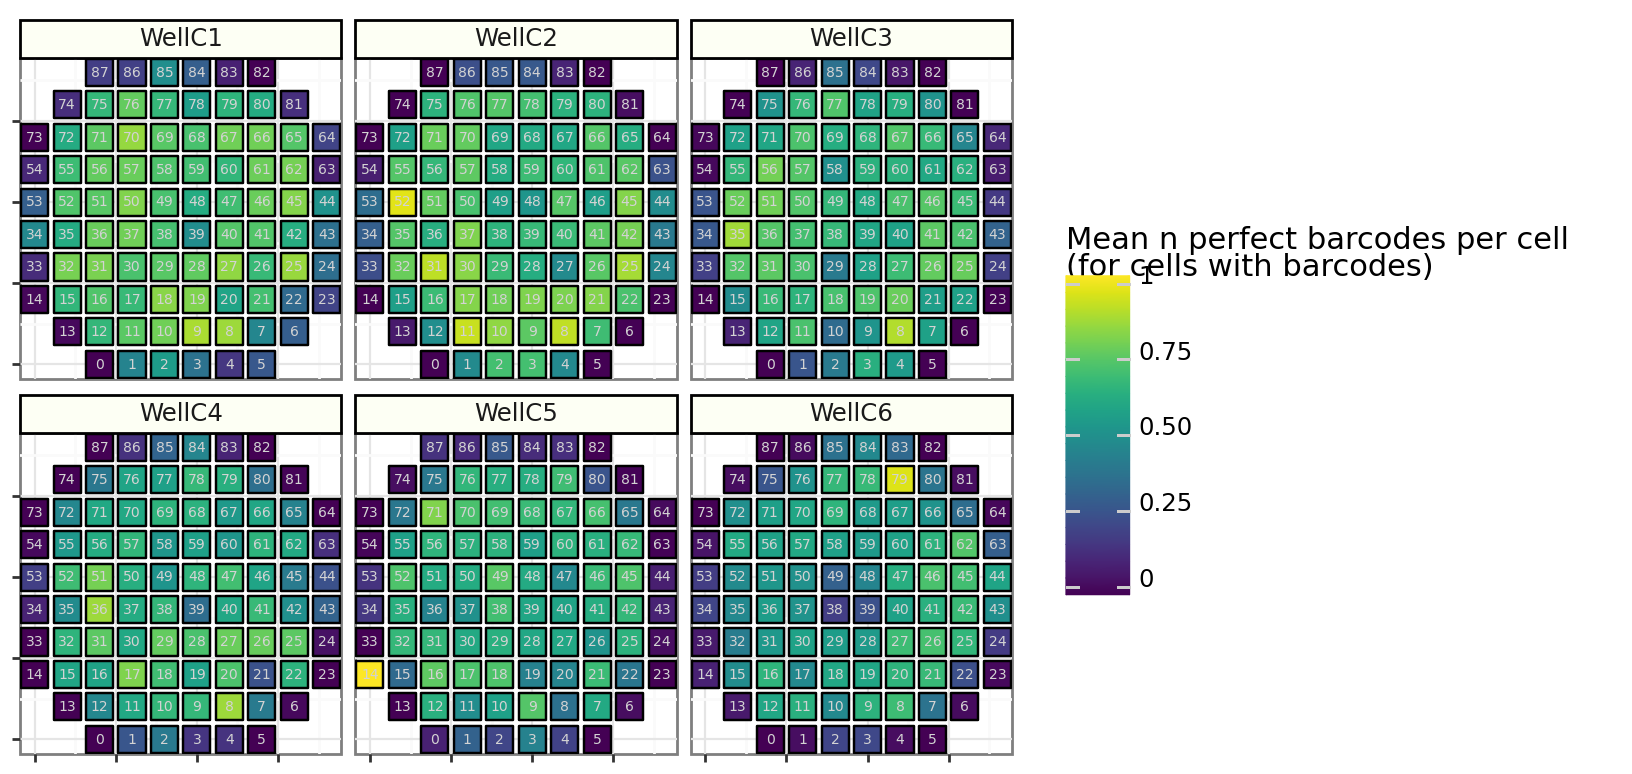

<ggplot: (8793165428008)>

In [46]:
# aggregate per-cell data by site and plot Count perfect barcodes by site

df_perfect_foci_per_cell_agg = (
    df_foci_per_cell.groupby(["Metadata_Well", "Metadata_Site"])
    .mean()
    .reset_index()
    .rename(columns={"Num_Perf": "Avg_n_perf_per_cell"})
)
df_perfect_foci_per_cell_agg = df_perfect_foci_per_cell_agg.merge(pos_df, on='Metadata_Site').reset_index()

gg_cells = (
    gg.ggplot(df_perfect_foci_per_cell_agg, gg.aes(x="x_loc", y="y_loc"))
    + gg.geom_point(gg.aes(fill="Avg_n_perf_per_cell"), shape="s", size=5)
    + gg.geom_text(gg.aes(label="Metadata_Site"), color="lightgrey", size=5)
    + gg.facet_wrap("~Metadata_Well")
    + gg.coord_fixed()
    + gg.theme_bw()
    + gg.theme(
        axis_text=gg.element_blank(),
        axis_title=gg.element_blank(),
        strip_background=gg.element_rect(colour="black", fill="#fdfff4"),
    )
    + gg.labs(fill="Mean n perfect barcodes per cell")
    + gg.scale_fill_cmap(name="Mean n perfect barcodes per cell \n(for cells with barcodes)")
)
# note missing sites indicate that site has zero perfect barcodes
gg_cells

## Log10 of space between the 10th percentile and 90th percentile of the distribution of counts for barcodes
## Number of cells with each barcode
